<a href="https://colab.research.google.com/github/divyam123-EECS-Physics/NetLoadForecastingScripts/blob/main/Universal_PyTorch2_trend_features_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Imports and Utilities

In [ ]:

import pandas as pd
!pip install solarforecastarbiter
!pip install TimezoneFinder

import numpy as np
import matplotlib.pyplot as plt
from timezonefinder import TimezoneFinder
import solarforecastarbiter.metrics
from solarforecastarbiter.metrics.probabilistic import continuous_ranked_probability_score,crps_skill_score
import solarforecastarbiter.reference_forecasts
from solarforecastarbiter.reference_forecasts.persistence import persistence_probabilistic_timeofday, persistence_probabilistic
# from gluonts.mx.model.deep_npts import DeepNPTSEstimator
import torch
import scipy as sp

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 53.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.7 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: requests
    Found existing installation: requests 2.27.1
    Uninstalling requests-2.27.1:
      Successfully uninstalled requests-2.27.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.27.1, 

In [ ]:
from timezonefinder import TimezoneFinder
states = {
    'hi': {
        "state_location":'hawaii',
        "lat":21.446911,
        "lon":-158.188736,
        "elevation":4.0,
        "fresh_data_time":'12',
        "reference_id":"c639b1f3-eb8f-11ed-802e-aec5a60999dc",
        "name":"Waianae, HI Substation",    },
    'or': {
        "state_location":'oregon',
        "lat":45.114559,
        "lon":-123.204903,
        "elevation":50.0,
        "fresh_data_time":'12',
        "reference_id":"5ebb4527-edbd-11ed-bf8d-128dcacebd72",
        "name":"Amity, OR Substation",
    },
    'tx': {
         "state_location":'texas',
        "lat":29.424122,
        "lon":-98.493629,
        "elevation":200.0,
        "fresh_data_time":'06',
        "reference_id":"8568f10f-eb8f-11ed-a556-128dcacebd72",
        "name":"San Antonio, TX Substation",

    },
    'ga': {
        "state_location":'georgia',
        "lat":31.044241,
        "lon":-84.879128,
        "elevation":0.0,
        "fresh_data_time":'06',
        "reference_id":"90c2a42c-f0ad-11ed-94b4-5edf5e2b3336",
        "name":"Donalsonville, GA Substation"
    },

}

tf = TimezoneFinder(in_memory=True)
for state in states:
  local_time_zone = tf.timezone_at(lng = states[state]['lon'], lat = states[state]['lat'])
  states[state]['local_time_zone'] = local_time_zone


tx_lon = -98.493629
tx_lat = 29.424122
ga_lon = -84.879128
ga_lat = 31.044241
or_lon = -123.204903
or_lat = 45.114559
hi_lat = 21.446911
hi_lon = -158.188736

from solarforecastarbiter.io import api
def upload_function(data_df, state = 'hi'):
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")
    if state == 'hi':

        hawaii_forecast_ids = [
           ["60534840-0044-11ee-8096-22bbbfba48a8", "p0"],
           ["60551d2e-0044-11ee-aea4-22bbbfba48a8", "p10"],
           ["60577a7c-0044-11ee-9d93-22bbbfba48a8", "p20"],
           ["6059b4ae-0044-11ee-b9f7-22bbbfba48a8", "p30"],
           ["605c7e09-0044-11ee-88c5-22bbbfba48a8", "p40"],
           ["605f5aad-0044-11ee-a68f-22bbbfba48a8", "p50"],
           ["6061a141-0044-11ee-b645-22bbbfba48a8", "p60"],
           ["6063f5d3-0044-11ee-a725-22bbbfba48a8", "p70"],
           ["606656a8-0044-11ee-aca6-22bbbfba48a8", "p80"],
           ["6069aa58-0044-11ee-b4a8-22bbbfba48a8", "p90"],
           ["606c387a-0044-11ee-92ea-22bbbfba48a8", "p100"],
        ]
        for uuid, col in hawaii_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'tx':
        tx_forecast_ids = [
           ["51936f7f-0044-11ee-8006-22bbbfba48a8", "p0"],
           ["5195a4a9-0044-11ee-9abe-22bbbfba48a8", "p10"],
           ["5199b969-0044-11ee-8c5b-22bbbfba48a8", "p20"],
           ["519be6af-0044-11ee-aa1b-22bbbfba48a8", "p30"],
           ["519e4691-0044-11ee-ace3-22bbbfba48a8", "p40"],
           ["51a07836-0044-11ee-b70a-22bbbfba48a8", "p50"],
           ["51a2b229-0044-11ee-9369-22bbbfba48a8", "p60"],
           ["51a54811-0044-11ee-9b1c-22bbbfba48a8", "p70"],
           ["51a78587-0044-11ee-ac5f-22bbbfba48a8", "p80"],
           ["51a96889-0044-11ee-95de-22bbbfba48a8", "p90"],
           ["51ac716f-0044-11ee-96a0-22bbbfba48a8", "p100"],
        ]
        for uuid, col in tx_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'or':

        or_forecast_ids = [
           ["58ea38ee-0044-11ee-abf9-aa678857fb1c", "p0"],
           ["58ecd0ac-0044-11ee-96ef-aa678857fb1c", "p10"],
           ["58efa6af-0044-11ee-a87e-aa678857fb1c", "p20"],
           ["58f2856f-0044-11ee-94d6-aa678857fb1c", "p30"],
           ["58f4d11c-0044-11ee-80ca-aa678857fb1c", "p40"],
           ["58f792d8-0044-11ee-869d-aa678857fb1c", "p50"],
           ["58fa355e-0044-11ee-881a-aa678857fb1c", "p60"],
           ["58fc98a1-0044-11ee-b2cb-aa678857fb1c", "p70"],
           ["58ff236c-0044-11ee-ba4c-aa678857fb1c", "p80"],
           ["5901b51f-0044-11ee-aae2-aa678857fb1c", "p90"],
           ["59045e2b-0044-11ee-8914-aa678857fb1c", "p100"],
        ]
        for uuid, col in or_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return
    if state == 'ga':

        ga_forecast_ids = [
           ["493ba331-0044-11ee-936c-aa678857fb1c", "p0"],
           ["493e3bce-0044-11ee-bdf4-aa678857fb1c", "p10"],
           ["4940a921-0044-11ee-8e27-aa678857fb1c", "p20"],
           ["49431d34-0044-11ee-a476-aa678857fb1c", "p30"],
           ["4945f80a-0044-11ee-8674-aa678857fb1c", "p40"],
           ["49489e6d-0044-11ee-8ce3-aa678857fb1c", "p50"],
           ["494b350e-0044-11ee-b5bc-aa678857fb1c", "p60"],
           ["494fe072-0044-11ee-bb2d-aa678857fb1c", "p70"],
           ["4952cab3-0044-11ee-afa5-aa678857fb1c", "p80"],
           ["4955940c-0044-11ee-a0c7-aa678857fb1c", "p90"],
           ["495827d0-0044-11ee-83b0-aa678857fb1c", "p100"],
        ]

        for uuid, col in ga_forecast_ids:
            upload_df = data_df[col]
            upload_df = upload_df.rename('value')
            print(upload_df)
            session.post_probabilistic_forecast_constant_value_values(uuid, upload_df)

        return


def get_reference_forecasts(location, start_date, end_date):
    # Access related parameters for Net Load Forecast Site
    email = 'nlf2023-coral@forecastarbiter.com'
    pwd =  'T3&b@O*KiGf$a@!@3LBv'
    start_datetime = start_date + ' 01:00:00'
    end_datetime = end_date + ' 00:00:00'
    #Reference Probablistic Persistance Ensemble Forecast
    locations = {'4a3de81c-0043-11ee-a474-aa678857fb1c':['Pacific/Honolulu','Waianae_Hawaii'],
                '49cdf54e-0043-11ee-a581-aa678857fb1c':['America/Los_Angeles','Amity_OR'],
                '496055a3-0043-11ee-ada4-aa678857fb1c':['America/Chicago','SanAntonio_TX'],
                '3b6b45e3-0043-11ee-bfe9-aa678857fb1c':['America/New_York','Donalsonville_GA']}
    locations_uuids = {
        'hi':'4a3de81c-0043-11ee-a474-aa678857fb1c',
        'or':'49cdf54e-0043-11ee-a581-aa678857fb1c',
        'tx':'496055a3-0043-11ee-ada4-aa678857fb1c',
        'ga':'3b6b45e3-0043-11ee-bfe9-aa678857fb1c'
    }
    # for uuid in locations.keys():
    uuid = locations_uuids[location]
    tmz=locations[uuid][0]

    token = api.request_cli_access_token(email, pwd)
    session = api.APISession(token, base_url="https://api.forecastarbiter.com")

    session.get_probabilistic_forecast(uuid)

    start = pd.Timestamp(start_datetime).tz_localize(tmz)
    end = pd.Timestamp(end_datetime).tz_localize(tmz)
    fdf = session.get_probabilistic_forecast_values(uuid, start, end)
    fdf = fdf.reset_index('timestamp')
    fdf = fdf.rename(columns = {'timestamp':'time'})
    fdf.time = fdf.time.dt.tz_convert(tmz)
    fdf.time = fdf.time.dt.tz_localize(None)
    return fdf

def crps_and_crpss_scores(obs, predictions, start_date, end_date, location):

    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
    reference_df = get_reference_forecasts(location, start_date, end_date)
    reference_val = reference_df.drop(columns = 'time').values

    crps = continuous_ranked_probability_score(obs, predictions, fx_prob)
    crpss = crps_skill_score(obs, predictions,  fx_prob, reference_val, fx_prob)

    return crps, crpss, reference_df


# Feature engineering


In [ ]:

state_location = 'hi'
training_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_historical.csv'.format(states[state_location]['state_location']))
total_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/training_datasets/{}_2022-01-01-2023-06-28_total.csv'.format(states[state_location]['state_location']))
test_data = pd.read_csv('/content/drive/MyDrive/net_load_forecasting/test_datasets/{}_2023-07-10_test.csv'.format(states[state_location]['state_location']))



In [ ]:
training_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)
test_data.rename(columns = {'Unnamed: 0':'time'}, inplace = True)

training_data.drop(columns = 'quality_flag', inplace = True)
test_data.drop(columns = 'quality_flag', inplace = True)

In [ ]:
test_data[-72-23-24:-23]

In [ ]:
training_data.time = pd.to_datetime(training_data.time)
test_data.time = pd.to_datetime(test_data.time)

In [ ]:
test_data

In [ ]:
training_data['hours'] = np.sin((training_data.time.dt.hour - 12) / 24)
test_data['hours'] = np.sin((test_data.time.dt.hour - 12) / 24)

In [ ]:

test_data

In [ ]:
test_data['sunrise'] = pd.to_datetime(test_data.sunrise)
test_data['sunset'] = pd.to_datetime(test_data.sunset)


test_data.sunrise = np.sin((test_data.sunrise.dt.hour + (test_data.sunrise.dt.minute / 60) - 12) / 24)
test_data.sunset = np.sin((test_data.sunset.dt.hour + (test_data.sunset.dt.minute / 60) - 12) / 24)

In [ ]:
# test_data

In [ ]:
training_data['sunrise'] = pd.to_datetime(training_data.sunrise)
training_data['sunset'] = pd.to_datetime(training_data.sunset)

training_data.sunrise = np.sin((training_data.sunrise.dt.hour + (training_data.sunrise.dt.minute / 60) - 12) / 24)
training_data.sunset = np.sin((training_data.sunset.dt.hour + (training_data.sunset.dt.minute / 60) - 12) / 24)

In [ ]:
training_data['month'] = np.sin(training_data.time.dt.month / 12)
test_data['month'] = np.sin(test_data.time.dt.month / 12)

In [ ]:
# training_data.shape
# ['prev_{}'.format(5) + '_' + col for col in training_data.drop(columns = 'time').columns]

In [ ]:
old_cols = training_data.drop(columns = 'time').columns
lookback_start = 2
lookback_dim = 6
lookback_end = lookback_dim + lookback_start - 1
trend_features = (len(old_cols) + 1) * lookback_dim
for j,i in enumerate(range(lookback_start, lookback_end + 1)):
  new_cols = ['prev_{}'.format(i) + '_' + col for col in old_cols]
  training_data[new_cols] = training_data.shift(i * 24)[old_cols].values
  training_data['lb_pos'] = j + 1
  test_data[new_cols] = test_data.shift(i * 24)[old_cols].values
  test_data['lb_pos'] = j + 1



In [ ]:
len(test_data.columns[-181:-163])

In [ ]:
# trend_features = len(old_cols) * lookback_dim


In [ ]:
# ['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]

In [ ]:
training_data['std'] = training_data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)
test_data['std'] = test_data[['prev_{}_value'.format(i) for i in range(lookback_start, lookback_end + 1)]].std(axis = 1)

In [ ]:
# training_data.columns

In [ ]:
# training_data = training_data[(training_data['prev_{}_value'.format(lookback_end)].isna() == False)].reset_index().drop(columns = 'index')

In [ ]:
training_data.iloc[:,-90:]

In [ ]:
new_df = training_data[(training_data.value.isna() == False) &
                   (training_data['prev_{}_value'.format(lookback_end)].isna() == False)].drop(columns = 'time')
# new_df = training_data[((training_data['time'] <= '2022-10-01 00:00:00') & (training_data['time'] >= '2022-05-01 00:00:00'))].drop(columns = 'time')


In [ ]:
# new_df.iloc[:,-trend_features:]

In [ ]:


val_df = test_data[(test_data.value.isna() == False) &
                   (test_data['prev_{}_value'.format(lookback_end)].isna() == False)].drop(columns = 'time')
test_df_new = test_data[test_data.value.isna() == True][-24-23:-23].reset_index().drop(columns = ['index','time'])

In [ ]:
test_data[(test_data.value.isna() == False) & (test_data['prev_{}_value'.format(lookback_end)].isna() == False)]

In [ ]:
val_df=val_df[new_df.columns]
test_df_new=test_df_new[new_df.columns]

# Train Val Split

In [ ]:
X_train = new_df[[col for col in new_df.columns if col != 'value']]
y_train = new_df.value
X_train = torch.from_numpy(X_train.values).to(torch.float64)
y_train = torch.from_numpy(y_train.values).to(torch.float64)


In [ ]:
X_val = val_df[[col for col in val_df.columns if col != 'value']]
y_val = val_df.value
X_val = torch.from_numpy(X_val.values).to(torch.float64)
y_val = torch.from_numpy(y_val.values).to(torch.float64)

# Defining models

In [ ]:
from re import X
class TrendsModel(nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim, lookback_dim):
    super(TrendsModel, self).__init__()
    self.encoding_layers = []
    self.lookback_dim = lookback_dim
    self.input_dim = input_dim
    for i in range(lookback_dim):
      # layer_1 = nn.Linear(input_dim // lookback_dim, int((input_dim // lookback_dim) * 0.5)).to(torch.float64)
      layer_1 = nn.Linear(input_dim // lookback_dim, int((input_dim // lookback_dim) * 0.8)).to(torch.float64)
      layer_2 = nn.Linear(int((input_dim // lookback_dim) * 0.8), int((input_dim // lookback_dim) * 0.5)).to(torch.float64)
      self.encoding_layers.append((layer_1, layer_2))

    self.fc1 = nn.Linear(int((input_dim // lookback_dim) * 0.5) * lookback_dim,
                         int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.25)).to(torch.float64)

    self.fc2 = nn.Linear(int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.25),
                         int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.25)).to(torch.float64)

    # self.fc2 = nn.Linear(int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.5),
                        #  lookback_dim).to(torch.float64)

    self.fc3 = nn.Linear(int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.25),
                         int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.25)).to(torch.float64)

    self.fc4 = nn.Linear(int((input_dim // lookback_dim) * 0.5 * lookback_dim * 0.25),
                         lookback_dim).to(torch.float64)

    self.fc5 = nn.Linear(lookback_dim, output_dim).to(torch.float64)
    self.lookback_dim = lookback_dim
    self.relu = nn.ReLU().to(torch.float64)
    self.softmax = nn.Softmax().to(torch.float64)

  def forward(self, x):
    daily_outputs = []
    for idx, (layer_1, layer_2) in enumerate(self.encoding_layers):
      x_daily = x[:,idx * (self.input_dim // lookback_dim):(idx + 1) * (self.input_dim // lookback_dim)]
      x_daily = self.relu(layer_1(x_daily))
      x_daily = self.relu(layer_2(x_daily))
      daily_outputs.append(x_daily)

    x = torch.concat(daily_outputs, dim = 1)

    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x) + x
    x = self.relu(x)
    x = self.fc3(x) + X
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    x = self.fc5(x)
    return x

class FeaturesModel(nn.Module):
    def __init__(self, input_dim, hidden_dim,output_dim):
        super(FeaturesModel, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim).to(torch.float64)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc4 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.fc6 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, 1).to(torch.float64)
        # self.fc7 = nn.Linear(hidden_dim, hidden_dim).to(torch.float64)
        self.relu = nn.ReLU().to(torch.float64)
        # self.softplus = nn.Softplus().to(torch.float64)
        self.softmax = nn.Softmax().to(torch.float64)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x) + X
        x = self.relu(x)
        x = self.fc3(x) + x
        x = self.relu(x)
        x = self.fc4(x) + x
        x = self.relu(x)
        x = self.fc5(x) + x
        x = self.relu(x)
        x = self.fc6(x) + x
        # x = self.relu(x)
        # x = self.fc7(x)
        return x

class Trend_Feature_model(nn.Module):
  def __init__(self, feature_dim, feature_hidden, trend_features_dim, hidden_dim, output_dim, lookback_dim = lookback_dim):
    super(Trend_Feature_model, self).__init__()
    self.trends_model = TrendsModel(trend_features_dim, hidden_dim, output_dim,lookback_dim)
    self.features_model = FeaturesModel(feature_dim, feature_hidden, output_dim)

    self.combining_layer = nn.Linear(feature_hidden +  output_dim, min([feature_hidden, output_dim])).to(torch.float64)
    self.output_layer = nn.Linear(min([feature_hidden, output_dim]), 1).to(torch.float64)
    self.lookback_dim = lookback_dim
    self.relu = nn.ReLU().to(torch.float64)
    self.trend_features_dim = trend_features_dim
    self.hidden_dim = hidden_dim

  def forward(self, x):
    x_features = x[:,:-1 * (self.trend_features_dim + 1)]
    x_lookback = x[:,-1 * (self.trend_features_dim + 1): -1]
    std_hour = x[:,-1].view(-1,1)
    feature_output = self.features_model(x_features)
    trends_output = self.trends_model(x_lookback)

    x = torch.concat([feature_output,trends_output], axis = 1).to(torch.float64)
    x = self.relu(x)
    x = self.combining_layer(x)
    x = self.relu(x)
    x = self.output_layer(x)




    vals = []
    for i in range(0, 11):
      q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

      #gaussian quantile func.
      pred2 = x + (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

      #uniform distribution:
      # b = x + (2 * std_hour)
      # a = x - (2 * std_hour)
      # pred2 = (b * q) + (a * (1 -  q))

      vals.append(pred2)

    x = torch.concat(vals, dim = 1)#.detach().numpy()

    return x



# Loss Functions

In [ ]:
def crps_loss(y_pred, y_obs):
    n = len(y_pred)
    fx = y_pred
    fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(y_pred.shape[0],1)
    # extend CDF min to ensure obs within forecast support
    # fx.shape = (n, d) ==> (n, d + 1)
    fx_min = torch.minimum(y_obs, y_pred[:, 0])
    y_pred = torch.hstack([fx_min[:, None], y_pred])
    fx_prob = torch.hstack([torch.zeros([n, 1]), fx_prob])

    # extend CDF max to ensure obs within forecast support
    # fx.shape = (n, d + 1) ==> (n, d + 2)
    idx = (fx[:, -1] < y_obs)
    fx_max = torch.maximum(y_obs, y_pred[:, -1])
    y_pred = torch.hstack([y_pred, fx_max[:, None]])
    fx_prob = torch.hstack([fx_prob, torch.full([n, 1], 100)])

    # indicator function:
    # - left of the obs is 0.0
    # - obs and right of the obs is 1.0
    o = torch.where(y_pred >= y_obs[:, None], 1.0, 0.0)

    # correct behavior when obs > max fx:
    # - should be 0 over range: max fx < x < obs
    o[idx, -1] = 0.0

    # forecast probabilities [unitless]
    f = fx_prob / 100.0
    # integrate along each sample, then average all samples
    crps = torch.mean(torch.trapezoid((f - o) ** 2, x=y_pred, axis=1))
    return crps# + torch.abs(((y_pred[:,5] - y_obs)) ** 2).mean()


def negLL(y_pred, y_true):
    mu = y_pred[:,6]
    # prob_0 = y_pred[:,0]
    # prob_100 = y_pred[:,-1]
    # print("y_pred.shape",y_pred.shape,"y_true.shape",y_true.shape)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((mu - y_true)/ 2) ** 2) #- torch.log(denom)
    # loss += 0.1 * (((prob_0 - y_true)/ 2) ** 2)
    # loss += 0.1 * (((prob_100 - y_true)/ 2) ** 2)
    return loss.mean()

def negLL2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = (((y_pred - obs)/ 2) ** 2) #- torch.log(denom)
    return loss.mean()

def mae(y_pred, y_true):
    mu = y_pred[:,0]
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((mu - y_true))) #- torch.log(denom)
    return loss.mean()

def mae2(y_pred, y_true):
    # mu = y_pred[:,0]
    num_quantiles = 11
    obs =  y_true.unsqueeze(1).repeat(1,num_quantiles)
    # sigma = y_pred[:,1]
    # denom = torch.sqrt(1/(2 * 2 * torch.pi))
    loss = torch.abs(((y_pred - obs)/ 2)) #- torch.log(denom)
    return loss.mean()

#Dataloader

In [ ]:

class CDataset(Dataset):
    def __init__(self, X, y):
        self.X = X#.values
        self.y = y#.values

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        return x, y

# Training Loop

In [ ]:
trend_features // lookback_dim, X_train.shape[1] - trend_features - 1

(19, 12)

In [ ]:
# from torch._C import float64
# Define the custom data loaders
batch_size = 64
train_dataset = CDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = CDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Initialize the model
feature_dim = X_train.shape[1] - trend_features - 1#22  # Specify the input feature dimensions
feature_hidden = 16
trend_features_dim = trend_features
lookback_hidden = int(trend_features * 0.8)

model = Trend_Feature_model(feature_dim = feature_dim, feature_hidden = int(feature_dim * 0.8),
                            trend_features_dim = trend_features_dim,
                            hidden_dim = lookback_hidden,
                            output_dim = 1)
# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

# Training loop
num_epochs = 150  # Specify the number of training epochs
train_losses = []
val_losses = []

for epoch in range(num_epochs):

    model.eval()  # Set the model to evaluation mode
    val_loss = 0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:

          outputs = model(batch_X)
          # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
          loss = crps_loss(outputs, batch_y)
          # loss = negLL(outputs, batch_y)
          val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    model.train()  # Set the model to training mode
    i = 0
    train_loss = 0


    for batch_X, batch_y in train_loader:#range(3):
        # Forward pass
        outputs = model(batch_X)
        # loss = crps_loss(outputs, batch_y) + negLL(outputs, batch_y)
        loss = crps_loss(outputs, batch_y)
        # loss = negLL(outputs, batch_y)
        i += 1
        train_loss += loss.item()
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss/len(train_loader))
    # Validation loop

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Val Loss: {val_loss}')


Epoch [1/150], Train Loss: 0.23802591979163337, Val Loss: 13.69954539869063
Epoch [2/150], Train Loss: 0.23117501870704915, Val Loss: 0.22975812078018698
Epoch [3/150], Train Loss: 0.19856621132711866, Val Loss: 0.22980103002665786
Epoch [4/150], Train Loss: 0.22177276527074702, Val Loss: 0.2296115669300266
Epoch [5/150], Train Loss: 0.21124074426599934, Val Loss: 0.22979079061509317
Epoch [6/150], Train Loss: 0.2495500112157628, Val Loss: 0.22978007542833218
Epoch [7/150], Train Loss: 0.25538794500560263, Val Loss: 0.22965493409264406
Epoch [8/150], Train Loss: 0.19982267365769332, Val Loss: 0.2295987787938543
Epoch [9/150], Train Loss: 0.3051039548092067, Val Loss: 0.22957224944039636
Epoch [10/150], Train Loss: 0.2218267259448894, Val Loss: 0.22980033447812842
Epoch [11/150], Train Loss: 0.2497688026189979, Val Loss: 0.22977879527983253
Epoch [12/150], Train Loss: 0.21280905940769684, Val Loss: 0.22973125983877196
Epoch [13/150], Train Loss: 0.2525060630503084, Val Loss: 0.229615169

In [ ]:
# test_data

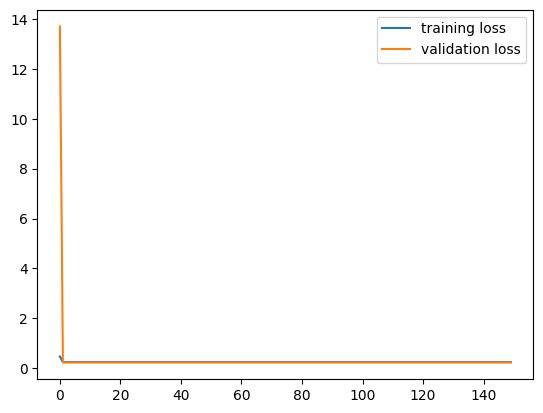

In [ ]:
plt.plot(train_losses, label = 'training loss')
plt.plot(val_losses, label = 'validation loss')
plt.legend()
plt.show()

# Inspection Space

In [ ]:
weather_cols = ['dewpoint_2m','relativehumidity_2m','temperature_2m',
                'apparent_temperature', 'precipitation', 'cloudcover', 'cloudcover_low',
                'cloudcover_mid', 'cloudcover_high', 'shortwave_radiation',
                'direct_radiation', 'diffuse_radiation', 'direct_normal_irradiance']
weather_dictionary = {col:[] for col in weather_cols}

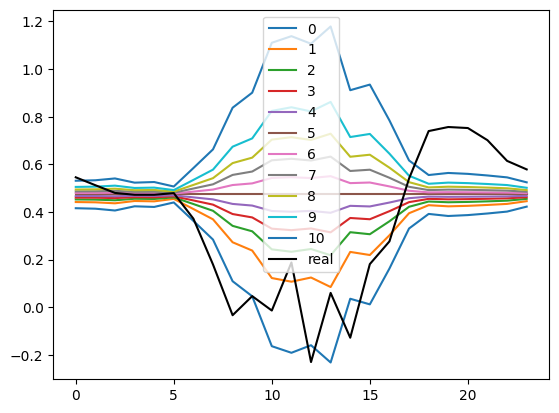

0.19344847833062065 -2.870521588356607


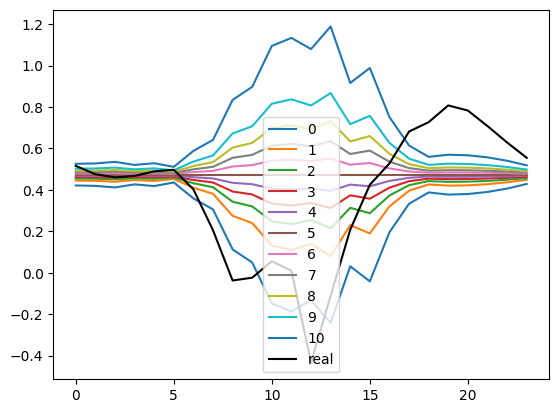

0.19812769007922845 -1.628980446990524


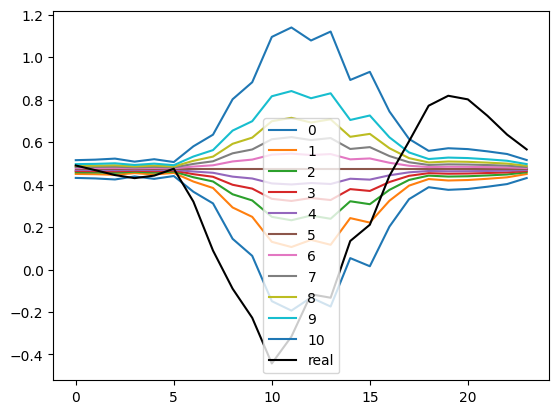

0.23572138253279087 -4.016354291086781


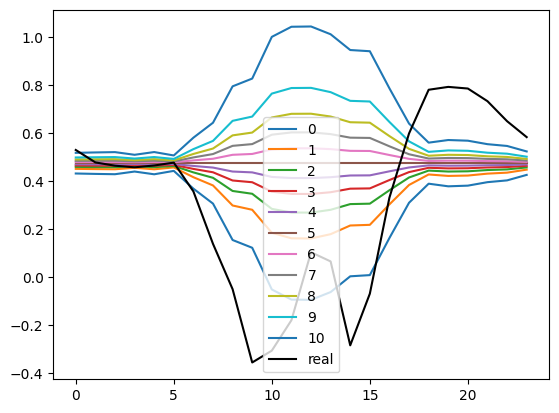

0.2509684599417599 -3.8716502218574016


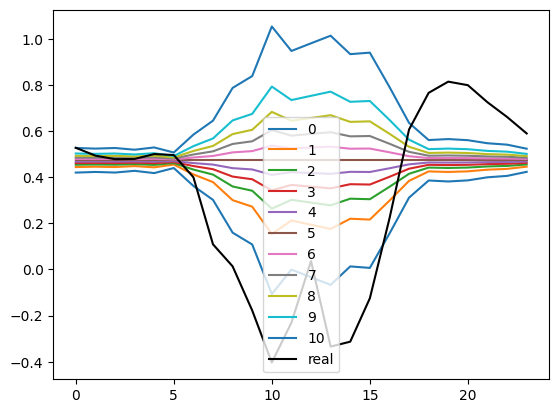

0.2714205467590746 -4.044344828089421


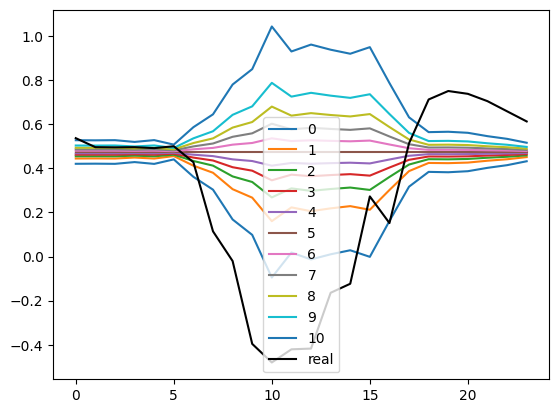

0.27814502860803264 -4.406571683036005


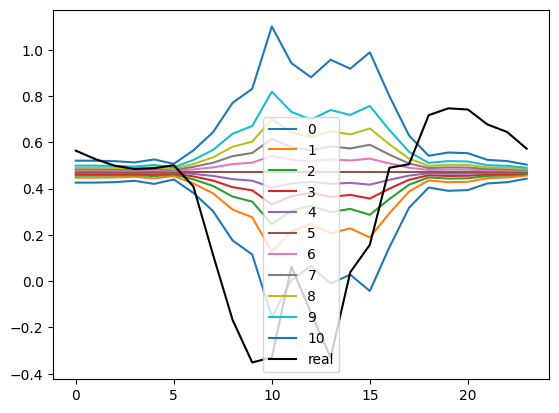

0.23699869941803173 -3.619061481864563


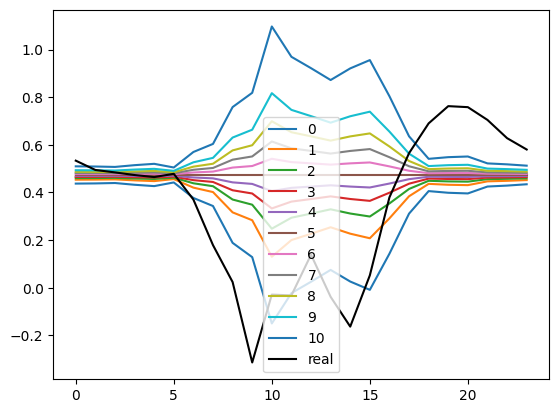

0.20886148245221955 -3.851523601279337


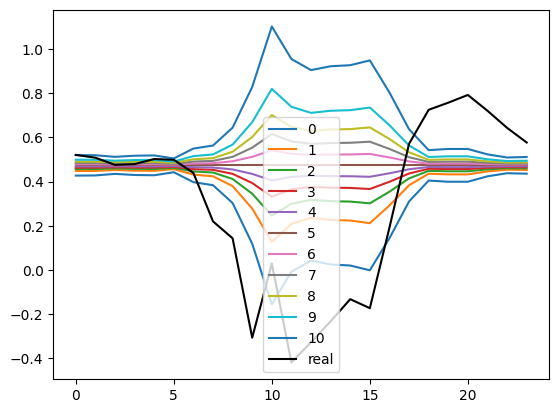

0.26377813745954215 -4.104790380149137


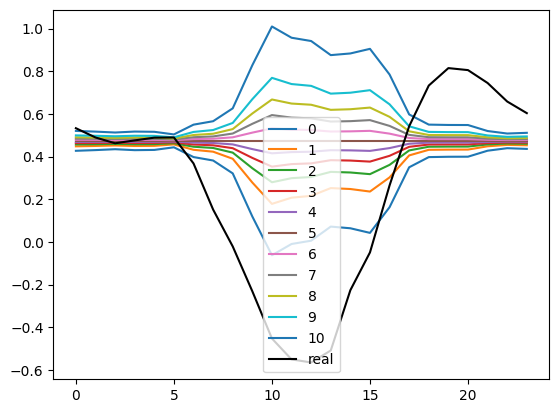

0.3226334790076875 -4.358821092740556


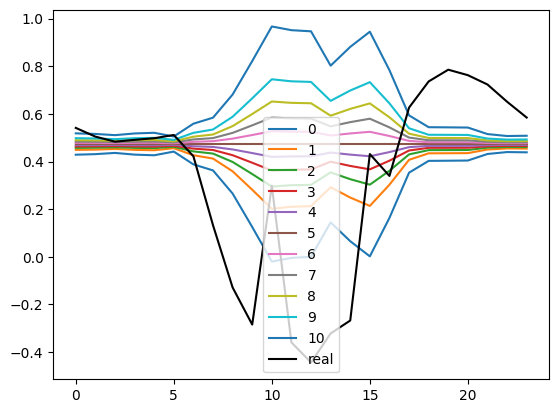

0.26124894845402613 -2.9117417409086106


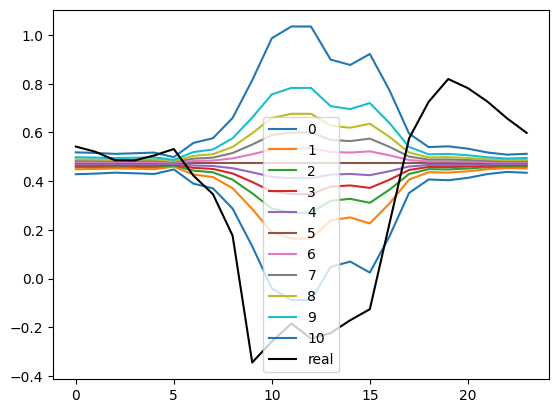

0.2614949345841712 -3.747462755830928


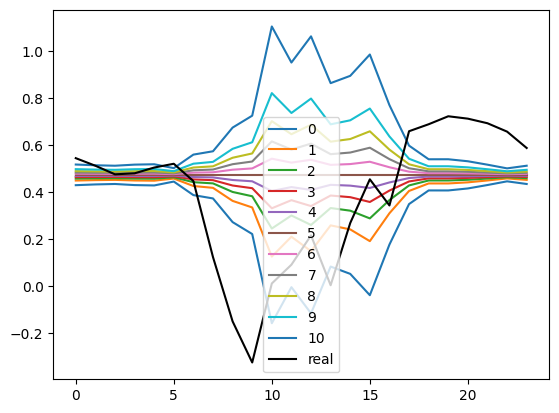

0.18758528165844024 -1.6215475280323028


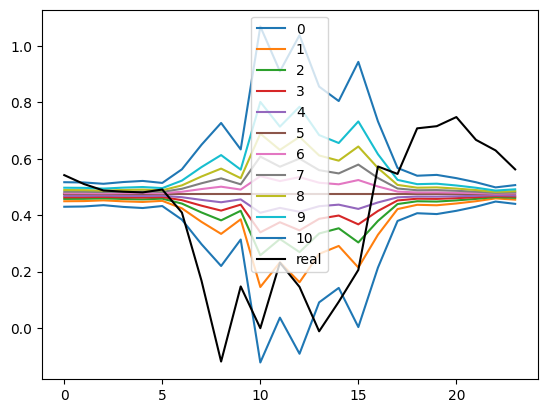

0.1780664313510744 -1.7842834269710348


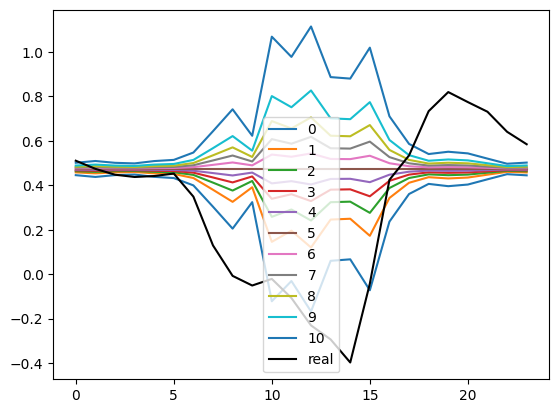

0.24583978691986405 -4.984750445288283


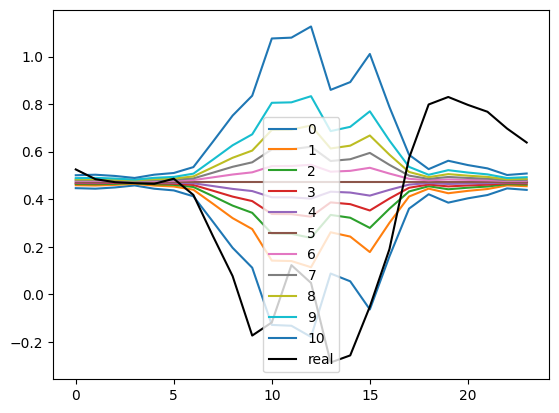

0.23262473784130266 -3.7612216889733796


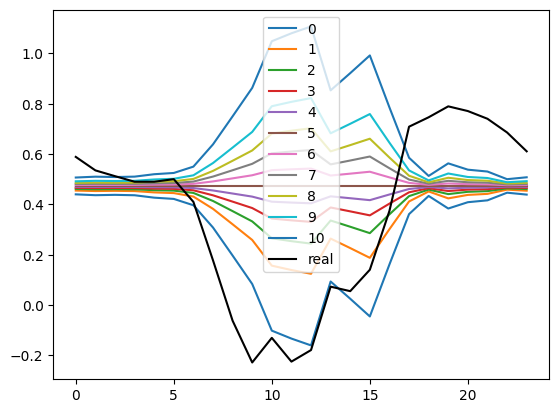

0.23408241120324366 -4.349716260083092


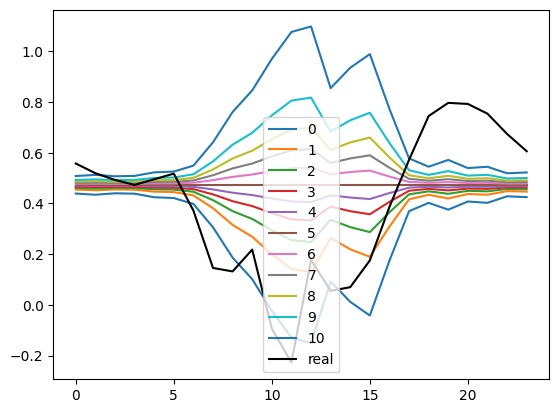

0.19035519520855174 -2.402258706394932


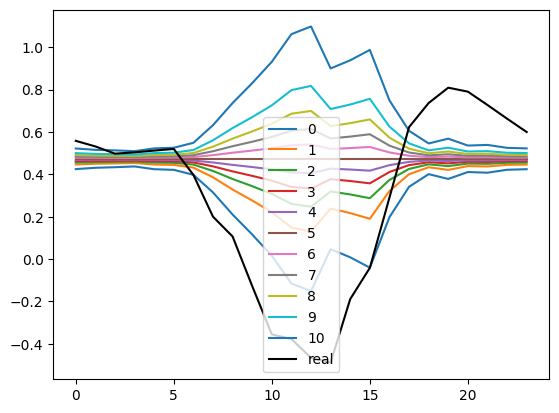

0.29113883225733955 -4.31281582125752


In [ ]:
daily_crps = []
daily_crpss = []
for month_prev, month, day in [(6,6,i) for i in range(19, 31)] + [(6,7,1),(7,7,2),(7,7,3),(7,7,4),(7,7,5),(7,7,6),(7,7,7)]:


  start_date = '2023-{:02d}-{:02d}'.format(month_prev, day - 1 if day != 1 else 30)
  end_date = '2023-{:02d}-{:02d}'.format(month, day)
  test_df = test_data[(test_data.time >= start_date + ' 01:00:00')
                    & (test_data.time <= end_date + ' 00:00:00')].drop(columns = 'time')

  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  hourly_deviations = []
  meanies = []
  std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


  vals = []
  for i in range(0, 11):
    # q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)

    pred2 = preds[:,i] #+ (1 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

    vals.append(pred2)
    plt.plot(pred2.detach().numpy(), label = str(i))

  plt.plot(y_test, color = 'black', label = 'real')
  plt.legend()
  plt.show()

  # for col in weather_cols:
  #   weather_data = test_df[col].values
  #   weather_dictionary[col].append(test_df[col].std())


  pred = preds.detach().numpy()#torch.concat(vals, dim = 1).detach().numpy()

  # submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
  # submission['timestamp'] = pd.date_range(start = '2023-06-{0:2d} 01:00:00'.format(day - 1),
  #                                         end =  '2023-06-{0:2d} 00:00:00'.format(day),
  #                                         freq='H',
  #                                         tz = states['ga']['local_time_zone']
  #                                         )

  # submission[['p' + str(i*10) for i in range(11)]] = pred



  obs = y_test.detach().numpy()
  fx_prob = torch.tensor([i for i in range(0,110,10)]).unsqueeze(0).repeat(24,1).numpy()
  crps, crpss, _ = crps_and_crpss_scores(obs, pred, start_date, end_date, state_location)
  print(crps, crpss)
  daily_crps.append(crps)
  daily_crpss.append(crpss)
  # submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/_new_model_June_{:02d}.csv".format(day))

# plt.plot(,daily_crps)
# plt.show()

## CRPSS Trend

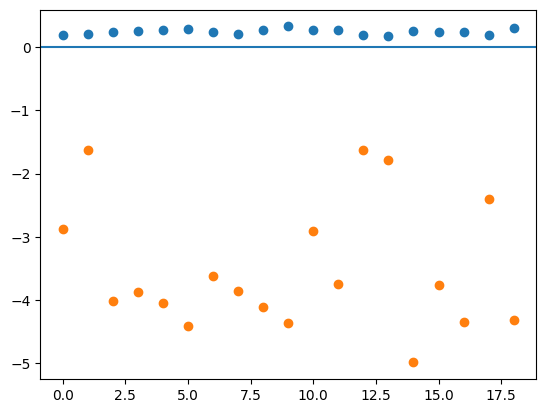

In [ ]:
plt.scatter(range(len(daily_crps)), daily_crps)
plt.scatter(range(len(daily_crpss)), daily_crpss)
plt.axhline(0)
plt.show()

<ipython-input-188-58bf7266af47>:7: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)


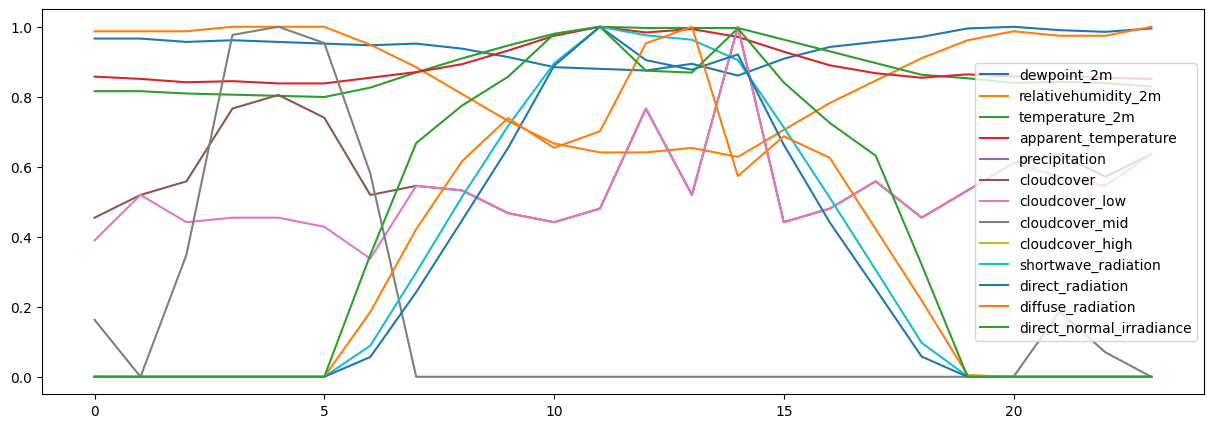

In [ ]:
day = 23
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  weather_dictionary[col].append(test_df[col].std())
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

<ipython-input-220-62c645e8ea18>:6: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)


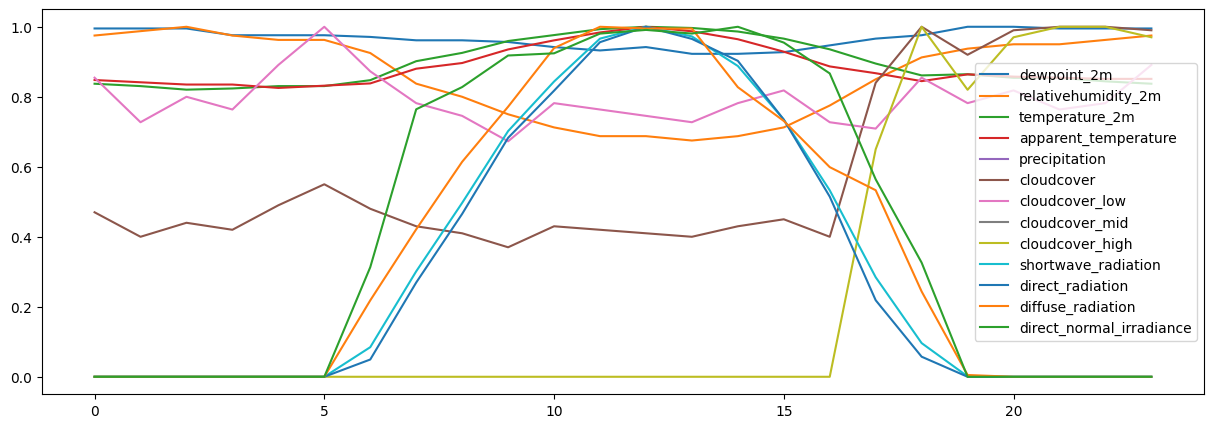

In [ ]:
day = 24
test_df = test_data[(test_data.time >= '2023-06-{:02d} 01:00:00'.format(day - 1)) & (test_data.time <= '2023-06-{:02d} 00:00:00'.format(day))].drop(columns = 'time')
plt.figure(figsize = (15,5))
for col in weather_cols:
  weather_data = test_df[col].values
  plt.plot(weather_data / np.max(np.abs(weather_data)), label = col)

plt.legend()
plt.show()

In [ ]:
# current_day = -1
# biases = []
# predictions = []
# observations = []
# for i in range(lookback_start, lookback_end + 1):
#   test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
#   X_test = test_df[[col for col in test_df.columns if col != 'value']]
#   y_test = test_df.value
#   X_test = torch.from_numpy(X_test.values).to(torch.float64)
#   y_test = torch.from_numpy(y_test.values).to(torch.float64)

#   preds = model(X_test)

#   predictions.append(preds)
#   observations.append(y_test)

# mean_pred = torch.zeros((24,1))
# mean_obs = torch.zeros((24,1))

# for i in range(lookback_dim):
#   mean_pred += predictions[i]
#   mean_obs += observations[i].view(24,1)

# mean_obs /= lookback_dim
# mean_pred /= lookback_dim

# test_df = test_data[-23-24:-23].drop(columns = 'time')
# X_test = test_df[[col for col in test_df.columns if col != 'value']]
# y_test = test_df.value
# X_test = torch.from_numpy(X_test.values).to(torch.float64)
# y_test = torch.from_numpy(y_test.values).to(torch.float64)

# preds = model(X_test)

# hourly_deviations = []
# meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)


# vals = []
# for i in range(0, 11):
#   q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
#   bias = mean_pred - mean_obs
#   corrected_mean = preds - bias


#   pred2 = preds + std_hour * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

#   vals.append(pred2)
#   plt.plot(pred2.detach().numpy(), label = str(i))

# plt.legend()
# plt.show()

# pred = torch.concat(vals, dim = 1).detach().numpy()


# BIAS CORRECTION AND SUBMISSION

In [ ]:
test_df = test_data[-23-24:-23].drop(columns = 'time')

In [ ]:
current_day = -1
biases = []
predictions = []
observations = []
for i in range(lookback_start, lookback_end + 1):
  test_df = test_data[(-24 * (i) + 1):(-24 * (i) + 1) + 24].drop(columns = 'time')
  X_test = test_df[[col for col in test_df.columns if col != 'value']]
  y_test = test_df.value
  X_test = torch.from_numpy(X_test.values).to(torch.float64)
  y_test = torch.from_numpy(y_test.values).to(torch.float64)

  preds = model(X_test)

  predictions.append(preds)
  observations.append(y_test)

mean_pred = torch.zeros((24,11))
mean_obs = torch.zeros((24,1))

for i in range(lookback_dim):
  mean_pred += predictions[i]
  mean_obs += observations[i].view(24,1)

mean_obs /= lookback_dim
mean_pred /= lookback_dim

In [ ]:
test_data[-23-24:-23]

In [ ]:
test_data[-23-24:-23]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_13_cloudcover_high,prev_13_shortwave_radiation,prev_13_direct_radiation,prev_13_diffuse_radiation,prev_13_direct_normal_irradiance,prev_13_sunset,prev_13_sunrise,prev_13_hours,prev_13_month,std
936,2023-07-10 01:00:00,NaN,27.4,77,23.0,31.0,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.442454,0.479426,0.039335
937,2023-07-10 02:00:00,NaN,26.9,79,22.9,30.9,0.0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.404715,0.479426,0.033393
938,2023-07-10 03:00:00,NaN,26.4,81,22.9,31.0,0.0,2,2,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.366273,0.479426,0.026756
939,2023-07-10 04:00:00,NaN,25.8,84,22.9,30.5,0.0,4,4,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.327195,0.479426,0.025023
940,2023-07-10 05:00:00,NaN,25.4,87,23.0,30.0,0.0,100,6,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.287549,0.479426,0.021400
941,2023-07-10 06:00:00,NaN,24.9,89,23.0,29.5,0.0,100,8,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.247404,0.479426,0.028527
942,2023-07-10 07:00:00,NaN,24.4,91,22.8,28.8,0.0,100,7,0,...,0.0,25.0,3.0,22.0,43.3,0.351364,-0.223106,-0.206830,0.479426,0.029985
943,2023-07-10 08:00:00,NaN,25.9,87,23.6,29.6,0.0,81,33,0,...,0.0,165.0,86.0,79.0,495.7,0.351364,-0.223106,-0.165896,0.479426,0.025705
944,2023-07-10 09:00:00,NaN,27.9,77,23.5,31.0,0.0,97,36,0,...,0.0,405.0,310.0,95.0,821.9,0.351364,-0.223106,-0.124675,0.479426,0.026653
945,2023-07-10 10:00:00,NaN,30.1,67,23.3,34.0,0.0,29,24,0,...,0.0,569.0,369.0,200.0,645.2,0.351364,-0.223106,-0.083237,0.479426,0.020394


In [ ]:
test_data[-23-24-23:-23-23]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_13_cloudcover_high,prev_13_shortwave_radiation,prev_13_direct_radiation,prev_13_diffuse_radiation,prev_13_direct_normal_irradiance,prev_13_sunset,prev_13_sunrise,prev_13_hours,prev_13_month,std
913,2023-07-09 02:00:00,NaN,27.8,73,22.5,31.4,0.0,3,3,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.404715,0.479426,0.034523
914,2023-07-09 03:00:00,NaN,27.4,78,23.2,31.6,0.0,10,10,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.366273,0.479426,0.027547
915,2023-07-09 04:00:00,NaN,26.7,81,23.1,30.7,0.0,8,8,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.327195,0.479426,0.025546
916,2023-07-09 05:00:00,NaN,25.9,84,22.9,30.4,0.0,3,3,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.287549,0.479426,0.021762
917,2023-07-09 06:00:00,NaN,25.3,86,22.7,29.5,0.0,15,15,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.247404,0.479426,0.028146
918,2023-07-09 07:00:00,NaN,25.2,89,23.3,29.8,0.0,17,17,0,...,0.0,29.0,6.0,23.0,86.0,0.351364,-0.223106,-0.206830,0.479426,0.029431
919,2023-07-09 08:00:00,NaN,26.3,85,23.5,30.3,0.0,27,27,0,...,0.0,205.0,114.0,91.0,655.4,0.351364,-0.223106,-0.165896,0.479426,0.026481
920,2023-07-09 09:00:00,NaN,27.9,75,23.0,31.3,0.0,17,17,0,...,0.0,298.0,175.0,123.0,462.9,0.351364,-0.223106,-0.124675,0.479426,0.026092
921,2023-07-09 10:00:00,NaN,30.0,65,22.7,33.4,0.0,6,6,0,...,0.0,662.0,484.0,178.0,845.2,0.351364,-0.223106,-0.083237,0.479426,0.021854
922,2023-07-09 11:00:00,NaN,32.2,57,22.6,36.6,0.0,1,1,0,...,0.0,828.0,712.0,116.0,960.2,0.351364,-0.223106,-0.041655,0.479426,0.038955


In [ ]:
test_df = test_data[-23-24:-23].drop(columns = 'time')#test_data[-23-24-24:-23-24].drop(columns = 'time')
test_df

,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,...,prev_13_cloudcover_high,prev_13_shortwave_radiation,prev_13_direct_radiation,prev_13_diffuse_radiation,prev_13_direct_normal_irradiance,prev_13_sunset,prev_13_sunrise,prev_13_hours,prev_13_month,std
936,NaN,27.4,77,23.0,31.0,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.442454,0.479426,0.039335
937,NaN,26.9,79,22.9,30.9,0.0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.404715,0.479426,0.033393
938,NaN,26.4,81,22.9,31.0,0.0,2,2,0,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.366273,0.479426,0.026756
939,NaN,25.8,84,22.9,30.5,0.0,4,4,0,0,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.327195,0.479426,0.025023
940,NaN,25.4,87,23.0,30.0,0.0,100,6,0,100,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.287549,0.479426,0.021400
941,NaN,24.9,89,23.0,29.5,0.0,100,8,0,100,...,0.0,0.0,0.0,0.0,0.0,0.351364,-0.223106,-0.247404,0.479426,0.028527
942,NaN,24.4,91,22.8,28.8,0.0,100,7,0,100,...,0.0,25.0,3.0,22.0,43.3,0.351364,-0.223106,-0.206830,0.479426,0.029985
943,NaN,25.9,87,23.6,29.6,0.0,81,33,0,81,...,0.0,165.0,86.0,79.0,495.7,0.351364,-0.223106,-0.165896,0.479426,0.025705
944,NaN,27.9,77,23.5,31.0,0.0,97,36,0,97,...,0.0,405.0,310.0,95.0,821.9,0.351364,-0.223106,-0.124675,0.479426,0.026653
945,NaN,30.1,67,23.3,34.0,0.0,29,24,0,29,...,0.0,569.0,369.0,200.0,645.2,0.351364,-0.223106,-0.083237,0.479426,0.020394


In [ ]:
model(X_test),X_test

(tensor([[0.4259, 0.4729, 0.4927, 0.5070, 0.5192, 0.5306, 0.5420, 0.5542, 0.5685,
          0.5883, 0.6353],
         [0.4427, 0.4817, 0.4981, 0.5100, 0.5201, 0.5296, 0.5391, 0.5492, 0.5610,
          0.5775, 0.6165],
         [0.4357, 0.4680, 0.4816, 0.4914, 0.4998, 0.5077, 0.5155, 0.5239, 0.5337,
          0.5473, 0.5796],
         [0.4429, 0.4693, 0.4804, 0.4884, 0.4953, 0.5017, 0.5081, 0.5149, 0.5230,
          0.5341, 0.5605],
         [0.4236, 0.4526, 0.4649, 0.4737, 0.4812, 0.4883, 0.4953, 0.5029, 0.5117,
          0.5239, 0.5530],
         [0.4225, 0.4523, 0.4649, 0.4739, 0.4817, 0.4889, 0.4961, 0.5038, 0.5129,
          0.5254, 0.5552],
         [0.4133, 0.4456, 0.4592, 0.4689, 0.4773, 0.4851, 0.4930, 0.5013, 0.5111,
          0.5247, 0.5570],
         [0.3692, 0.3959, 0.4072, 0.4153, 0.4222, 0.4287, 0.4352, 0.4421, 0.4502,
          0.4615, 0.4882],
         [0.4276, 0.4430, 0.4495, 0.4541, 0.4581, 0.4619, 0.4656, 0.4696, 0.4743,
          0.4808, 0.4962],
         [0.5082, 0

In [ ]:
test_data[-23-24-16:-23-16]

,time,value,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,precipitation,cloudcover,cloudcover_low,cloudcover_mid,...,prev_13_cloudcover_high,prev_13_shortwave_radiation,prev_13_direct_radiation,prev_13_diffuse_radiation,prev_13_direct_normal_irradiance,prev_13_sunset,prev_13_sunrise,prev_13_hours,prev_13_month,std
920,2023-07-09 09:00:00,NaN,27.9,75,23.0,31.3,0.0,17,17,0,...,0.0,298.0,175.0,123.0,462.9,0.351364,-0.223106,-0.124675,0.479426,0.026092
921,2023-07-09 10:00:00,NaN,30.0,65,22.7,33.4,0.0,6,6,0,...,0.0,662.0,484.0,178.0,845.2,0.351364,-0.223106,-0.083237,0.479426,0.021854
922,2023-07-09 11:00:00,NaN,32.2,57,22.6,36.6,0.0,1,1,0,...,0.0,828.0,712.0,116.0,960.2,0.351364,-0.223106,-0.041655,0.479426,0.038955
923,2023-07-09 12:00:00,NaN,34.4,46,21.1,38.7,0.0,0,0,0,...,0.0,949.0,838.0,111.0,959.8,0.351364,-0.223106,0.000000,0.479426,0.050973
924,2023-07-09 13:00:00,NaN,36.1,42,21.1,40.8,0.0,0,0,0,...,0.0,1017.0,909.0,108.0,948.4,0.351364,-0.223106,0.041655,0.479426,0.045154
925,2023-07-09 14:00:00,NaN,37.3,37,20.1,41.1,0.0,0,0,0,...,0.0,1023.0,915.0,108.0,922.6,0.351364,-0.223106,0.083237,0.479426,0.047795
926,2023-07-09 15:00:00,NaN,38.1,34,19.5,41.5,0.0,0,0,0,...,0.0,967.0,862.0,105.0,887.9,0.351364,-0.223106,0.124675,0.479426,0.045499
927,2023-07-09 16:00:00,NaN,38.6,32,18.9,41.1,0.0,0,0,0,...,0.0,857.0,757.0,100.0,844.0,0.351364,-0.223106,0.165896,0.479426,0.042569
928,2023-07-09 17:00:00,NaN,38.8,32,19.1,40.6,0.0,0,0,0,...,0.0,690.0,599.0,91.0,772.7,0.351364,-0.223106,0.206830,0.479426,0.046120
929,2023-07-09 18:00:00,NaN,38.2,31,18.1,38.7,0.0,0,0,0,...,0.0,488.0,406.0,82.0,661.3,0.351364,-0.223106,0.247404,0.479426,0.050077


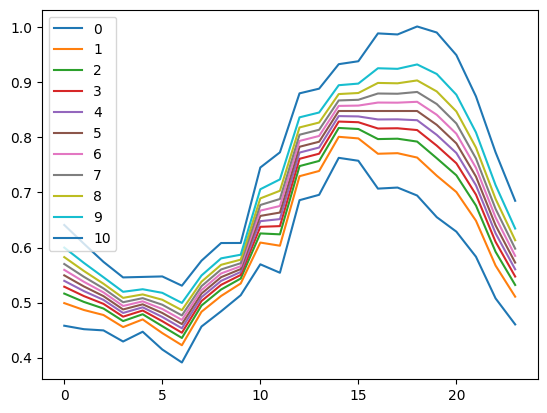

In [ ]:
# j = 1
# trial_x, trial_y = X_test[-24 * (j): -24 * (j-1)], y_test[-24 * (j): -24 * (j-1)]

test_df = test_data[-23-24:-23].drop(columns = 'time')#test_data[-23-24-24:-23-24].drop(columns = 'time')
X_test = test_df[[col for col in test_df.columns if col != 'value']]
y_test = test_df.value
X_test = torch.from_numpy(X_test.values).to(torch.float64)
y_test = torch.from_numpy(y_test.values).to(torch.float64)

preds = model(X_test)#torch.from_numpy(X).to(torch.float64))#.shape

hourly_deviations = []
meanies = []
# std_hour = X_test[:,-lookback_dim:].std(dim = 1).view(24,1)#new_df[new_df['hour'] == float(i)]['value'].std()


vals = []
for i in range(0, 11):
  q = i/10 if i not in [0,10] else (0.01 if i == 0 else 0.99)
  bias = mean_pred - mean_obs
  corrected_mean = preds - bias#(preds - mean)


  # pred2 = preds[:,i]# +  (2 * std_hour) * torch.sqrt(torch.tensor(2)) * torch.erfinv(torch.tensor((2 * q) - 1))

  # vals.append(pred2)
  plt.plot(preds[:,i].detach().numpy(), label = str(i))

plt.legend()
plt.show()

# pred = preds.detach().numpy()

In [ ]:
preds

tensor([[0.4580, 0.4991, 0.5164, 0.5288, 0.5395, 0.5495, 0.5594, 0.5701, 0.5826,
         0.5999, 0.6410],
        [0.4517, 0.4866, 0.5012, 0.5118, 0.5209, 0.5293, 0.5378, 0.5469, 0.5575,
         0.5721, 0.6070],
        [0.4495, 0.4774, 0.4892, 0.4977, 0.5049, 0.5117, 0.5185, 0.5258, 0.5342,
         0.5460, 0.5740],
        [0.4293, 0.4554, 0.4665, 0.4744, 0.4812, 0.4875, 0.4938, 0.5006, 0.5086,
         0.5196, 0.5457],
        [0.4470, 0.4694, 0.4788, 0.4856, 0.4914, 0.4968, 0.5023, 0.5081, 0.5148,
         0.5243, 0.5466],
        [0.4148, 0.4446, 0.4571, 0.4662, 0.4739, 0.4811, 0.4884, 0.4961, 0.5052,
         0.5177, 0.5475],
        [0.3912, 0.4225, 0.4357, 0.4452, 0.4534, 0.4610, 0.4685, 0.4767, 0.4862,
         0.4994, 0.5307],
        [0.4565, 0.4834, 0.4947, 0.5028, 0.5098, 0.5163, 0.5228, 0.5298, 0.5379,
         0.5492, 0.5761],
        [0.4842, 0.5120, 0.5238, 0.5322, 0.5394, 0.5462, 0.5529, 0.5602, 0.5686,
         0.5803, 0.6082],
        [0.5134, 0.5347, 0.5437, 0.55

# Submission Block

In [ ]:
from datetime import datetime


In [ ]:
# submission = pd.DataFrame(columns = ['timestamp']+['p' + str(i*10) for i in range(11)])
# submission['timestamp'] = pd.date_range(start = '2023-07-03 01:00:00',
#                                          end =  '2023-07-04 00:00:00',
#                                          freq='H',
#                                          tz = states[state_location]['local_time_zone']
#                                          )
# submission[['p' + str(i*10) for i in range(11)]] = pred

# submission.to_csv("/content/drive/MyDrive/net_load_forecasting/submissions/hi_pytorch2_submission_{}.csv".format(datetime.now()))

# upload_function(submission.set_index('timestamp'),state_location)